In [1]:
import itertools
import sys
sys.path.append("../")
from pomps.policy_scope import PolicyComponent, MixedPolicyScope
from pomis.scm import *
import networkx as nx
from pomps.contextual_graphs import *
from pomps.policy_scope import *
from pomps.gp_fcm import *
from pomps.controllers import *
import pyro
import torch
from tqdm.auto import tqdm
import pyro.distributions as dist
from pomps.fcm import *
import seaborn as sns
import matplotlib.pyplot as plt
# from pomis.optimiser import CausalOptimiser, Objective, SCM
from pomis.scm import BoolDomain, SCM


In [2]:
def sampler_over():
    u1 = pyro.sample("U1", dist.Uniform(-1, 1))
    u2 = pyro.sample("U2", dist.Uniform(-1, 1))
    return {"U1": u1, "U2": u2}
fcm = FunctionalCausalModel({Functor(lambda U1: pyro.sample("C", dist.Normal(U1, 0.1)), 'C'),
                             Functor(lambda C, U1: pyro.sample("X1", dist.Normal(U1+C, 0.1)), 'X1'),
                             Functor(lambda C, X1, U2: pyro.sample("X2", dist.Normal(C+X1+torch.abs(U2)*0.3, 0.1)), 'X2'),
                             Functor(lambda U2, X2, C: pyro.sample("Y", 
                                        dist.Normal(torch.cos(C-X2)+U2/100, 0.01)), "Y")}, sampler_over)

# def model(count):
#     with pyro.plate("samples", count):
#         age = pyro.sample("age", dist.Uniform(55, 76))
#         bmi = pyro.sample("bmi", dist.Normal(27, 0.7))

#         aspirin_p = torch.sigmoid(-8.0 + 0.10 * age + 0.03 * bmi)
#         statin_p = torch.sigmoid(-13.0 + 0.10 * age + 0.20 * bmi)

#         aspirin = pyro.sample("aspirin", dist.Bernoulli(aspirin_p))
#         statin = pyro.sample("statin", dist.Bernoulli(statin_p))

#         cancer_p = torch.sigmoid(2.2 - 0.05 * age + 0.01 * bmi - 0.04 * statin + 0.02 * aspirin)
#         cancer = pyro.sample("cancer", dist.Bernoulli(cancer_p))

#         mean = 6.8 + 0.04 * age - 0.15 * bmi - 0.60 * statin + 0.55 * aspirin + 1.00 * cancer
#         y = pyro.sample("y", dist.Normal(mean, 0.4))
#     return y
# scm = SCM(model, [BoolDomain('aspirin'), BoolDomain('statin')], non_man={'age', 'bmi', 'cancer'})
# aspirin_graph = scm.induced_graph()
# ccg = ContextualCausalGraph(edges=aspirin_graph, interventional_variables={"aspirin", "statin"}, 
#                       contextual_variables={"age", "bmi"}, target='y')
# ccg = MPSDAGController.simplify(ccg)

In [3]:
sum([fcm.sample()["Y"] for i in range(1000)])/1000

tensor(0.4550)

In [4]:
MixedPolicyScope({})

In [5]:
aspirin_graph = fcm.induced_graph()
ccg = ContextualCausalGraph(edges=aspirin_graph, interventional_variables={"X1", "X2"}, 
                      contextual_variables={"C", "X1"}, target='Y')
ccg = MPSDAGController.simplify(ccg)
space = [RealDomain("X1", -2, 2), RealDomain("X2", -2, 2), RealDomain("C", -2, 2)]
gpf = GPFunctorFactory(space)

In [6]:
ccg.interventional_variables, ccg.contextual_variables, ccg.uc_variables

({'X1', 'X2'}, {'C', 'X1'}, {'U1', 'U2'})

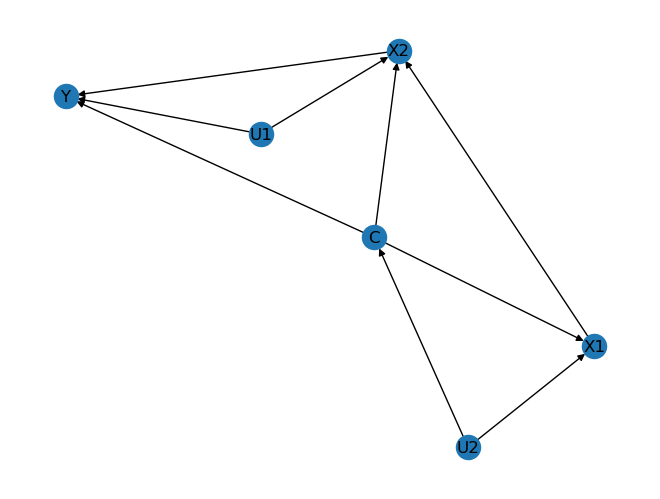

In [7]:
nx.draw(ccg, with_labels=True)

In [8]:
interventional_set = ccg.interventional_variables
contextual_set = ccg.contextual_variables

In [9]:
def all_combs(base, start=0):
    return list(itertools.chain(*[itertools.combinations(base, i) for i in range(start, len(base)+1)]))

def inter_cont_pair_gen(interventional_set, contextual_set):
    inter_segment = []
    context_space = all_combs(contextual_set)
    for inter in interventional_set:
        inter_segment += [[(inter, i) for i in context_space]]
    
    iam = all_combs(inter_segment)
    return itertools.chain(*[(itertools.product(*iam[i])) for i in range(len(iam))], [])

def mpss(pair_gen):
    for mps_row in pair_gen:
        yield MixedPolicyScope({PolicyComponent(target, set(context))  for target, context in mps_row })

In [10]:
a = {1}
b = a
b = b | {2}

In [11]:
a, b

({1}, {1, 2})

In [12]:
mpses = list(mpss(inter_cont_pair_gen(interventional_set, contextual_set)))
print(len(mpses))
graph_under_mps = [(MPSDAGController.graph_under_mps(mps, ccg), mps) for mps in mpses]
print(len(graph_under_mps))

graph_under_mps = [(g[0][0], g[1]) for g in graph_under_mps if g[0][1]]
print(len(graph_under_mps))

graph_under_mps = [g for g in graph_under_mps if MPSReductor.action_relevance_check(g[1], g[0]) and MPSReductor.context_relevance_check(g[1], g[0])]
print(len(graph_under_mps))
graph_under_mps = [g for g in graph_under_mps if not MPSReductor.sufficiently_not_pomp(g[1], g[0])]
print(len(graph_under_mps))

25
25
15
7
3


In [13]:
is_single_gp = True

In [14]:
graph_under_mps

[(<pomps.contextual_graphs.ContextualCausalGraph at 0x7ff6a0274b20>, ),
 (<pomps.contextual_graphs.ContextualCausalGraph at 0x7ff6c20b77c0>,
  <X1, {'C'}>),
 (<pomps.contextual_graphs.ContextualCausalGraph at 0x7ff6a06db640>,
  <X2, {'C'}>)]

In [15]:
del  graph_under_mps[0]

In [16]:
MixedPolicyScope({}) == graph_under_mps[0][1]

False

In [17]:
list(filter(None, [1,2,None,4,None,6]))

[1, 2, 4, 6]

In [18]:
pomps_active = {}
for idx, (graph, mps) in enumerate(graph_under_mps):
    if is_single_gp:
        policy = PolicyFCM.mps_to_single_gp(mps, gpf)
    else:
        policy = PolicyFCM.mps_to_gp_policy(mps, gpf)
    fcm_m = PolicyFCM.fcm_with_policy(fcm, policy)
    pomps_active[idx] = (fcm_m, list(policy)[0], mps)

In [19]:
list(pomps_active.values())[0][1].functional.optimizer

In [20]:
list(pomps_active.values())[1][1].functional.optimizer

In [21]:
pomps_active[0][0].functors

{'C': <pomps.fcm.Functor at 0x7ff6a068bdc0>,
 'Y': <pomps.fcm.Functor at 0x7ff6a068bf70>,
 'X1': <pomps.gp_fcm.SharedFunctor at 0x7ff680f160a0>,
 'X2': <pomps.fcm.Functor at 0x7ff6a068beb0>}

In [22]:
pomps_active[1][0].functors

{'C': <pomps.fcm.Functor at 0x7ff6a068bdc0>,
 'Y': <pomps.fcm.Functor at 0x7ff6a068bf70>,
 'X1': <pomps.fcm.Functor at 0x7ff6a068bf40>,
 'X2': <pomps.gp_fcm.SharedFunctor at 0x7ff6a0274910>}

In [23]:
# graph, mps = graph_under_mps[-1]
# nx.draw(graph, with_labels=True)
# is_single_gp = True
# if is_single_gp:
#     policy = PolicyFCM.mps_to_single_gp(mps, gpf)
# else:
#     policy = PolicyFCM.mps_to_gp_policy(mps, gpf)
# fcm_m = PolicyFCM.fcm_with_policy(fcm, policy)

In [24]:
 def not_dominated(a, b):
        return (np.asarray(a) <= b).any()

In [25]:
# X = np.random.randn(1000,2)
def not_dominated(a, b):
    return (np.asarray(a) >= b).any()
    
def pareto_optimals(X):
    from scipy.spatial.distance import cdist

    X = cdist(X, X, metric=not_dominated).astype(np.bool)
    non_dominated = np.where(X.all(axis=1))[0]
    return non_dominated

# pareto_optimals(X)

In [26]:
from collections import defaultdict

In [27]:
interv = union([v.interventional_variables for _, _, v in (pomps_active.values())])
arguments = union([v.contextual_variables for _, _, v in (pomps_active.values())])

In [28]:
pomps_active

{0: (<pomps.fcm.FunctionalCausalModel at 0x7ff680af8ac0>,
  <X1, {'C'}>),
 1: (<pomps.fcm.FunctionalCausalModel at 0x7ff680af81f0>,
  <X2, {'C'}>)}

In [29]:
pomps_active

{0: (<pomps.fcm.FunctionalCausalModel at 0x7ff680af8ac0>,
  <X1, {'C'}>),
 1: (<pomps.fcm.FunctionalCausalModel at 0x7ff680af81f0>,
  <X2, {'C'}>)}

In [30]:
results = defaultdict(lambda: [])
for i in tqdm(range(1000)):
    print("-"*50)
    trial_index = None
    try:
        trial_index = [idx for idx, (f, p, _) in enumerate(pomps_active.values()) if p.acq_vals is None][0]
        print("None detected")
    except IndexError as _:
        fold = np.row_stack([p.acq_vals for f, p, _ in pomps_active.values()])
        print("Folds", fold)
        optimals = pareto_optimals(fold)
        print("Optimals", optimals)
        trial_index = np.random.choice(optimals)
#     trial_index=0
    results['trial_id'].append(trial_index)
    
    fcm_m, policy, mps = pomps_active[trial_index]
    if is_single_gp:
            print("Policy for", policy.variable, policy.arguments)

    print("Trial index", trial_index)
    smp = fcm_m.sample(necessary_context=policy.arguments)
    print(smp)

    print("Acq vals", policy.acq_vals)
    for arg in arguments:
        if arg in mps.contextual_variables:
            results[f"arg_{arg}"].append(torch.tensor([smp[arg]]).item())
        else:
            results[f"arg_{arg}"].append(None)
    for var in interv:
        if var in mps.interventional_variables:
            results[f"int_{var}"].append(torch.tensor([smp[var]]).item())
        else:
            results[f"int_{var}"].append(None)
    y = smp[graph.target]
    y = torch.tensor([y])
    
    results['Y'].append(y.item())

    if is_single_gp:
        policy.functional.observe(-y)
    else:
        for p in policy:
            p.functional.observe(-y)


  0%|          | 0/1000 [00:00<?, ?it/s]

--------------------------------------------------
None detected
Policy for X1 {'C'}
Trial index 0
Inner  hebo {'X1': -2.0} None
{'C': tensor(-0.7439), 'X1': -2.0, 'X2': tensor(-2.3197), 'Y': tensor(-0.0183)}
Acq vals None
--------------------------------------------------
None detected
Policy for X1 {'C'}
Trial index 0
Inner  hebo {'X1': 0.0} None
{'C': tensor(-0.8498), 'X1': 0.0, 'X2': tensor(-0.7382), 'Y': tensor(1.0092)}
Acq vals None
--------------------------------------------------
None detected
Policy for X1 {'C'}
Trial index 0
Inner  hebo {'X1': 1.0} None
{'C': tensor(-0.5436), 'X1': 1.0, 'X2': tensor(0.4482), 'Y': tensor(0.5314)}
Acq vals None
--------------------------------------------------
None detected
Policy for X1 {'C'}
Trial index 0
Cont X tensor([[-2.0000, -0.7439],
        [ 0.0000, -0.8498],
        [ 1.0000, -0.5436]])
Enum X tensor([], size=(3, 0), dtype=torch.int64)
PyMoo [[-2.97356701e+00  1.44452763e+00  6.97256505e-01]
 [-2.09843850e+00  1.20848930e+00  1.042

PyMoo [[-2.06108594e+00  1.13218419e-01 -0.00000000e+00]
 [-2.13904929e+00  2.82427013e-01  2.38418608e-07]
 [-2.08400941e+00  1.24310389e-01 -0.00000000e+00]
 [-2.19920731e+00  4.82257307e-01  1.63318055e-05]
 [-1.86591482e+00  9.20028165e-02 -0.00000000e+00]
 [-2.04396701e+00  1.01750784e-01 -0.00000000e+00]
 [-1.83534098e+00  2.68930141e-02 -0.00000000e+00]
 [-2.18808842e+00  2.92683214e-01  2.38418608e-07]
 [-2.13293695e+00  1.61039069e-01 -0.00000000e+00]
 [-2.23199034e+00  9.10897970e-01  3.42442142e-03]
 [-1.76256561e+00 -1.61799230e-02 -0.00000000e+00]
 [-1.95873916e+00  9.51988921e-02 -0.00000000e+00]]
          X2               C  \
0   1.984618  tensor(0.3722)   
1   1.992503  tensor(0.3722)   
2   1.993508  tensor(0.3722)   
3   1.982294  tensor(0.3722)   
4   1.999356  tensor(0.3722)   
5   1.999357  tensor(0.3722)   
6   1.995878  tensor(0.3722)   
7   1.973007  tensor(0.3722)   
8   1.999910  tensor(0.3722)   
9   1.982294  tensor(0.3722)   
10  1.973039  tensor(0.3722) 

PyMoo [[-1.98999059  1.2521137   0.25949788]
 [-2.94413424  1.29586864  0.55281508]
 [-2.95636702  1.40875733  0.54388702]
 [-2.91594958  1.19542897  0.40020394]
 [-3.11315012  1.63783467  0.816643  ]
 [-3.12923408  1.74549818  0.87731427]
 [-2.96307993  1.47666156  0.68328798]
 [-1.81936932  1.20785844  0.15279898]
 [-1.81667125  1.30780029  0.08702234]
 [-1.94296992  1.45843017  0.16102667]
 [-3.24734735  1.76354516  0.89671409]
 [-3.31801772  2.22504425  1.3651197 ]
 [-1.93744814  1.31362009  0.14275454]
 [-3.25727201  2.39069247  1.33009744]
 [-2.07458758  1.29421091  0.24913271]
 [-3.08524418  1.52674258  0.73289359]
 [-3.19655395  1.59912765  0.88170969]
 [-3.01265097  1.50790012  0.69930643]
 [-1.95011258  1.34563136  0.19089977]
 [-2.32082582  1.12452734  0.33111197]
 [-3.39144921  2.60566545  1.62413383]
 [-1.93297911  1.27158713  0.20649187]
 [-1.74618959  1.19675279  0.11313712]
 [-2.61646295  1.05592275  0.35360798]
 [-1.61434388  1.18130088  0.06764463]
 [-3.41236115  2.97

PyMoo [[-3.27650261  1.13198817  0.49110231]
 [-3.1321187   1.21503782  0.40523756]
 [-3.19332862  1.24829555  0.47466815]
 [-3.72111964  1.57082081  0.83485752]
 [-3.12340403  1.10080421  0.39411178]
 [-3.55332327  1.50462365  0.84645593]
 [-2.72213626  0.75511014  0.14933366]
 [-3.35583878  1.27846563  0.61879033]
 [-3.31388998  1.24921167  0.65815312]
 [-2.89134693  0.94472235  0.28941846]
 [-3.07834244  0.93826729  0.34074041]
 [-3.42089939  1.30243111  0.70238495]
 [-3.74348068  1.90904915  1.14745319]
 [-3.29888535  1.22370207  0.61155111]
 [-3.12573528  1.18899953  0.47407532]
 [-3.74351978  1.93097425  1.19293892]
 [-3.10022545  1.08913994  0.34331489]
 [-3.54826355  1.45970476  0.76469165]
 [-2.95394993  0.97183812  0.25480154]
 [-3.44882965  1.31854177  0.64256293]
 [-3.8185544   1.98582566  1.25197232]
 [-2.89382911  0.95210397  0.31089646]]
          X2               C  \
0  -0.258423  tensor(0.3464)   
1  -0.102985  tensor(0.3464)   
2  -0.162754  tensor(0.3464)   
3  -0.3

PyMoo [[-3.15411067  1.77764928  1.12814629]
 [-3.53649378  2.31975055  1.53409457]
 [-3.40585494  2.27047682  1.49724901]
 [-3.34372473  2.08814025  1.35639262]
 [-3.28639603  2.08666563  1.35829949]
 [-3.50122452  2.27473092  1.50175571]
 [-3.22885633  2.01064539  1.29876113]
 [-3.34616089  2.23143339  1.46832395]
 [-3.46772099  2.28463483  1.49425733]
 [-3.72114086  2.39785004  1.58897185]
 [-3.23277617  2.01428294  1.29586029]]
          X2               C  \
0   0.468098  tensor(0.6536)   
1   0.484640  tensor(0.6536)   
2   0.465576  tensor(0.6536)   
3   0.337540  tensor(0.6536)   
4   0.424416  tensor(0.6536)   
5   0.400526  tensor(0.6536)   
6   0.484224  tensor(0.6536)   
7   0.436527  tensor(0.6536)   
8   0.243894  tensor(0.6536)   
9   0.288818  tensor(0.6536)   
10  0.288673  tensor(0.6536)   

                                             __AC_VAL  
0   [-3.1541106700897217, 1.7776492834091187, 1.12...  
1   [-3.5364937782287598, 2.3197505474090576, 1.53...  
2   [-3.405

PyMoo [[-2.08660698  1.2625922   0.3159444 ]
 [-1.81779385  1.31325984  0.09535389]
 [-3.16432643  1.60904157  0.94365525]
 [-3.04111242  1.56766593  0.76982814]
 [-2.30580854  1.65631485  0.51457977]
 [-2.23082685  1.50918484  0.43329912]
 [-2.50548506  1.70757413  0.50106138]
 [-1.88921738  1.46265781  0.20096615]
 [-2.30529547  1.56876504  0.51344365]
 [-2.64469218  1.42902744  0.52456874]
 [-3.18418646  1.55547655  0.94803607]
 [-3.59737825  1.71530426  1.06411624]
 [-2.29222512  1.50738895  0.49252516]
 [-3.83418989  2.40087104  1.67103887]
 [-2.35117579  1.52647829  0.52447188]
 [-3.40310764  1.70943356  1.04054916]
 [-3.82205915  2.26232529  1.57225001]
 [-2.67673302  1.44831705  0.536376  ]
 [-2.07562065  1.54452038  0.27701691]
 [-1.764431    1.33826792  0.0392717 ]
 [-1.94015574  1.67540967  0.21458498]
 [-3.00391436  1.39778709  0.61213249]
 [-3.22732353  1.66560316  0.90484977]
 [-3.76394653  2.09853554  1.39410651]
 [-1.85501528  1.3471452   0.15751888]
 [-2.09700489  1.49

PyMoo [[-3.66185045  2.10861588  1.35591817]
 [-3.73601151  2.69241595  1.83262074]
 [-3.29649544  1.71090293  1.07018697]
 [-3.51096153  1.87392044  1.21845722]
 [-3.41519952  1.76769292  1.16102993]
 [-3.31784534  1.83269536  1.13406241]
 [-3.71011257  2.48671913  1.68757522]
 [-3.54494214  1.914698    1.23109281]
 [-3.51011467  1.91184461  1.19181192]]
         X2                C  \
0 -0.861006  tensor(-0.9025)   
1 -0.934972  tensor(-0.9025)   
2 -0.885878  tensor(-0.9025)   
3 -0.994880  tensor(-0.9025)   
4 -1.075153  tensor(-0.9025)   
5 -0.798737  tensor(-0.9025)   
6 -0.997100  tensor(-0.9025)   
7 -0.931397  tensor(-0.9025)   
8 -0.798737  tensor(-0.9025)   

                                            __AC_VAL  
0  [-3.6618504524230957, 2.1086158752441406, 1.35...  
1  [-3.736011505126953, 2.692415952682495, 1.8326...  
2  [-3.2964954376220703, 1.7109029293060303, 1.07...  
3  [-3.5109615325927734, 1.8739204406738281, 1.21...  
4  [-3.4151995182037354, 1.7676929235458374, 1

PyMoo [[-1.83794487  5.46169901  3.79280758]
 [-1.55981112  1.89660442  0.29813561]
 [-1.81639862  2.53051424  0.61051023]
 [-1.59276628  2.47214317  0.48748118]
 [-1.49627185  1.87781     0.28639242]
 [-1.56387186  2.10450888  0.36936975]
 [-2.0863266   6.25543499  4.57430935]
 [-1.41893983  1.57920647  0.17044236]
 [-1.84010291  5.62129498  3.91238165]
 [-1.92636442  5.88144159  4.17620802]
 [-1.8822906   5.73088598  4.03207207]
 [-1.38514566  1.57848036  0.12126314]
 [-1.86392951  5.69453526  4.06053591]]
          X1               C  \
0  -1.264462  tensor(0.0136)   
1  -0.376196  tensor(0.0136)   
2  -0.306161  tensor(0.0136)   
3  -0.193573  tensor(0.0136)   
4  -0.366424  tensor(0.0136)   
5  -0.306161  tensor(0.0136)   
6  -1.364871  tensor(0.0136)   
7  -0.412013  tensor(0.0136)   
8  -1.240069  tensor(0.0136)   
9  -1.275826  tensor(0.0136)   
10 -1.264462  tensor(0.0136)   
11 -0.255732  tensor(0.0136)   
12 -1.347248  tensor(0.0136)   

                                     

PyMoo [[-2.14621949e+00  1.65748346e+00  2.45067865e-01]
 [-1.85914767e+00  9.26831424e-01  1.52149256e-02]
 [-2.03876376e+00  1.58608139e+00  1.94385394e-01]
 [-1.95727885e+00  1.06708598e+00  3.65769453e-02]
 [-1.76099706e+00  7.89802849e-01  1.04078976e-02]
 [-2.01511121e+00  1.03966630e+00  5.47031648e-02]
 [-1.71394420e+00  7.69238889e-01  5.39036421e-03]
 [-1.59939981e+00  6.27368391e-01  3.56737815e-04]
 [-1.93799412e+00  9.13957059e-01  2.71751378e-02]
 [-1.84377098e+00  7.59601533e-01  1.19868824e-02]]
         X1                C  \
0 -0.398300  tensor(-0.6934)   
1 -0.274250  tensor(-0.6934)   
2 -0.347934  tensor(-0.6934)   
3 -0.303659  tensor(-0.6934)   
4 -0.330061  tensor(-0.6934)   
5 -0.429106  tensor(-0.6934)   
6 -0.271858  tensor(-0.6934)   
7 -0.181661  tensor(-0.6934)   
8 -0.378784  tensor(-0.6934)   
9 -0.378777  tensor(-0.6934)   

                                            __AC_VAL  
0  [-2.146219491958618, 1.657483458518982, 0.2450...  
1  [-1.8591476678848


KeyboardInterrupt



In [31]:
results = {k: v[:len(results['Y'])]for k,v in results.items()}

In [32]:
df = pd.DataFrame({k: v[:len(results['Y'])]for k,v in results.items()}).reset_index()

<AxesSubplot:xlabel='int_X1', ylabel='arg_C'>

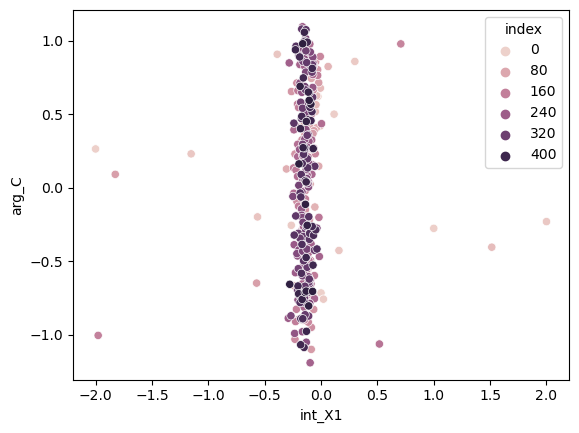

In [33]:
sns.scatterplot("int_X1", "arg_C",data=df, hue='index')

In [34]:
import pickle

In [35]:
# with open("results_pomps_paper_example.bin", "wb") as fd:
#     pickle.dump(results, fd)

<AxesSubplot:xlabel='int_X2', ylabel='arg_C'>

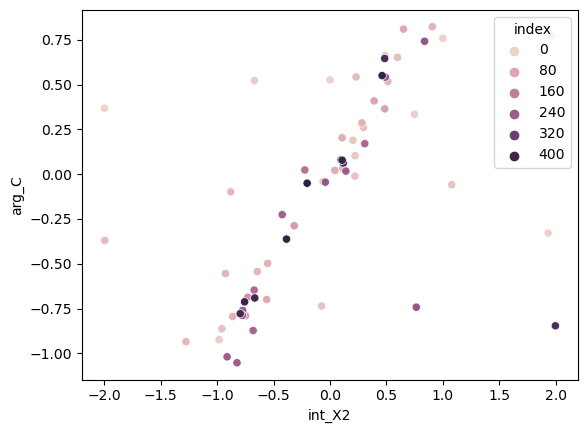

In [36]:
sns.scatterplot("int_X2", "arg_C",data=df, hue='index')

<AxesSubplot:xlabel='index', ylabel='trial_id'>

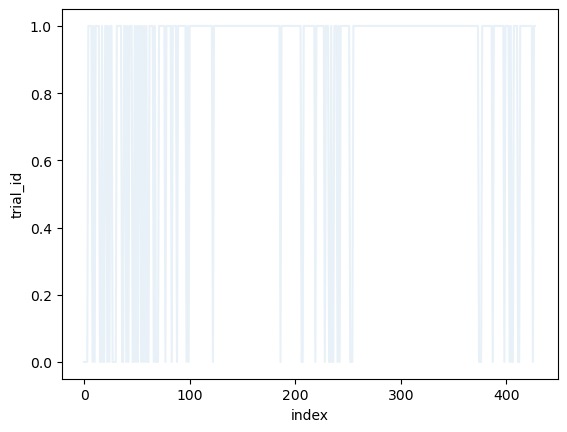

In [37]:
sns.lineplot(data=df, x="index", y="trial_id",alpha=0.1,)

<AxesSubplot:xlabel='trial_id', ylabel='index'>

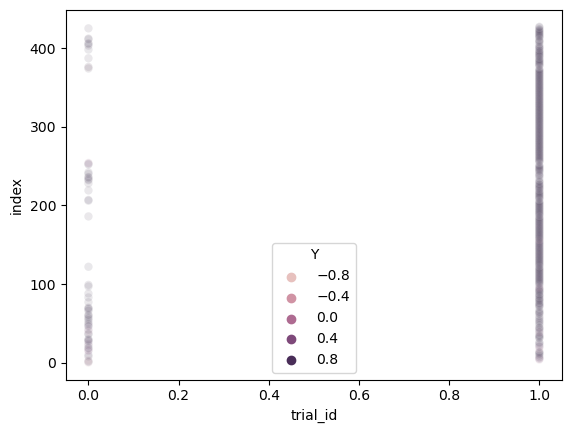

In [38]:
sns.scatterplot(data=df, x="trial_id", y="index", hue='Y',alpha=0.1,)

In [39]:
df["CUM_REG"] = (1-df['Y']).cumsum()
df["CUM_REG_M"] = df["CUM_REG"]/(df["index"] + 1)

<AxesSubplot:xlabel='index', ylabel='Y'>

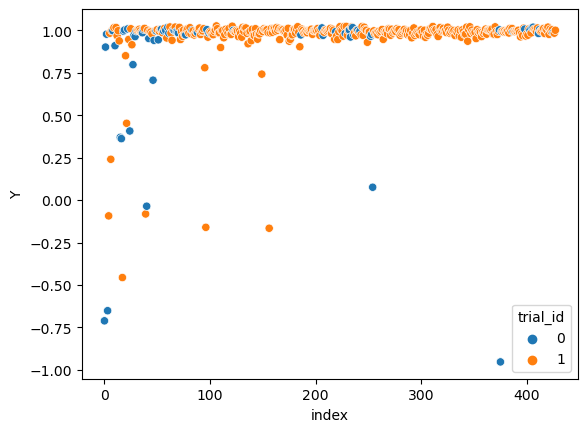

In [40]:
sns.scatterplot("index", "Y", data=df, hue='trial_id')

<AxesSubplot:xlabel='index', ylabel='CUM_REG'>

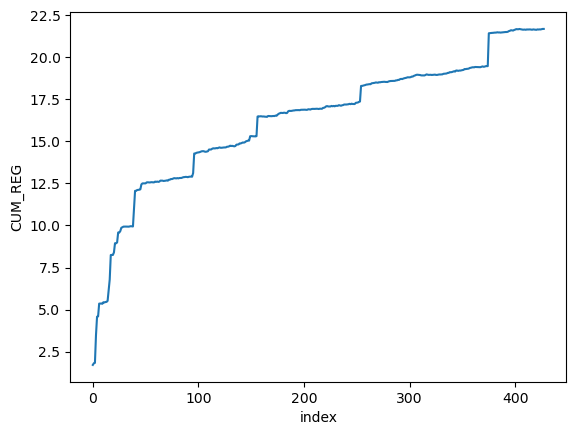

In [41]:
sns.lineplot("index", "CUM_REG", data=df)

<AxesSubplot:xlabel='index', ylabel='CUM_REG_M'>

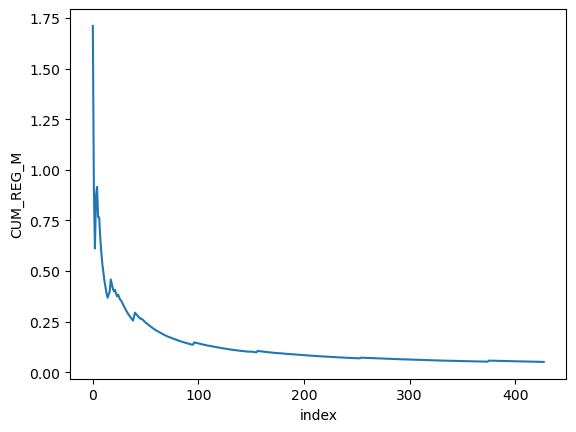

In [42]:
sns.lineplot("index", "CUM_REG_M", data=df)

In [28]:
import pickle 
with open('temp_res.bin', "wb") as fd: 
    pickle.dump(dict(results), fd)

In [29]:
for k,v in results.items():
    print(k, len(v))

trial_id 678
arg_C 677
int_X2 677
int_X1 677
Y 677


In [30]:
pomps_active[0]

(<pomps.fcm.FunctionalCausalModel at 0x7fb2f838aeb0>,
 <X1, {'C'}>)

In [48]:
 np.array(results["int_X2"])

array([-5.00000000e+00,  0.00000000e+00,  2.50000000e+00,  2.88187599e+00,
       -2.76688766e+00,  3.72562385e+00, -4.99735069e+00, -4.99917173e+00,
       -2.35988975e-01,  3.68504733e-01,  8.36614668e-01, -4.81353045e+00,
        3.33927691e-01, -5.80706224e-02, -5.91347873e-01,  5.36904335e-01,
        2.69833475e-01, -3.67526054e-01, -3.14037770e-01,  4.98794842e+00,
       -8.31889212e-01,  7.19358921e-01, -1.28295219e+00,  4.52464700e-01,
       -1.54751912e-01, -1.38887537e+00, -7.71355629e-01, -2.10756049e-01,
       -3.73264432e-01,  3.83386277e-02, -1.73288081e-02,  2.51333117e-01,
        2.73469537e-01, -1.96115673e-01,  5.13704360e-01, -4.44872618e+00,
       -9.30718184e-01,  1.60902369e+00,  1.47449344e-01, -3.17411184e+00,
        2.72266954e-01,  6.17187878e-04,  5.50645106e-02,  4.99877644e+00,
        4.61303234e+00,  3.61435980e-01,  5.00145018e-01,  1.08852375e+00,
       -5.09934723e-02, -6.52949512e-01,  4.99748611e+00,  7.56283581e-01,
        4.99973965e+00, -

In [53]:
np.array(results["arg_C"])[np.array(results["trial_id"])== 0].shape

(248,)

In [52]:
 np.array(results["int_X2"]).shape

(248,)

In [57]:
1/len(np.array(results["arg_C"])[np.array(results["trial_id"])== 0])

0.004032258064516129

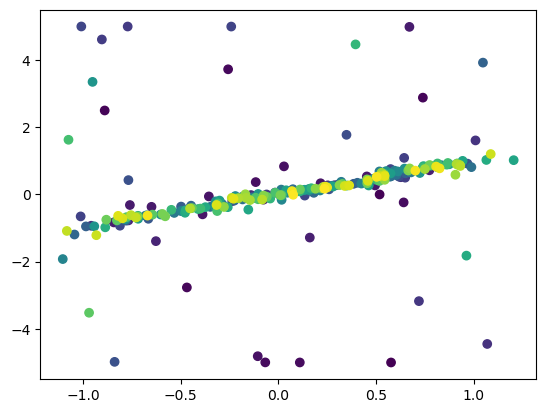

In [58]:
plt.scatter(np.array(results["arg_C"])[np.array(results["trial_id"])== 0], np.array(results["int_X2"]), c=np.arange(0,1,1/len(np.array(results["arg_C"])[np.array(results["trial_id"])== 0])))

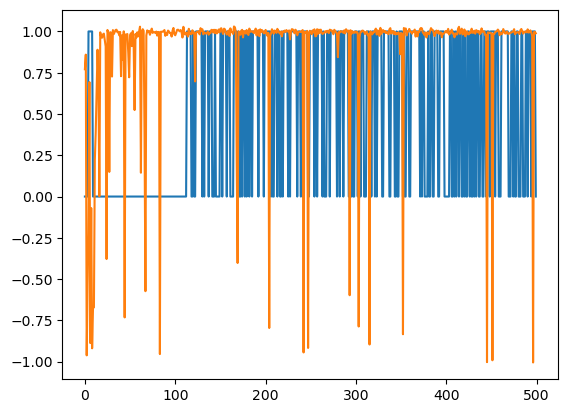

In [29]:
plt.plot(results["trial_id"][:len(results["Y"])])
plt.plot(results["Y"])


<AxesSubplot:xlabel='trial_id', ylabel='Y'>

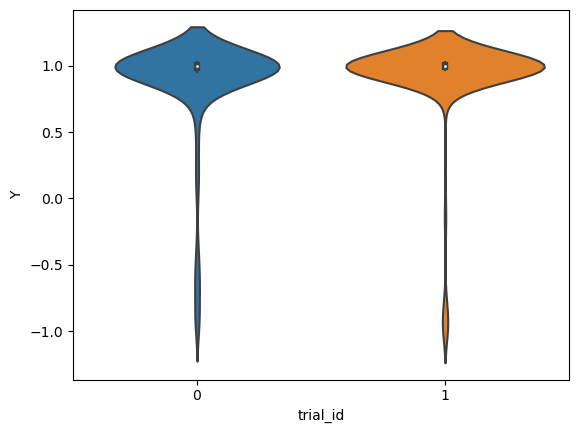

In [30]:
# plt.plot(results["trial_id"])
df = pd.DataFrame({"trial_id": results["trial_id"][:len(results["Y"])], "Y": results["Y"]})
sns.violinplot(data=df, x="trial_id", y="Y")
# df["trial_id"].plot()

In [31]:
df = pd.DataFrame(results)
df["Y"].plot()
df["trial_id"].plot()

ValueError: All arrays must be of the same length

<AxesSubplot:>

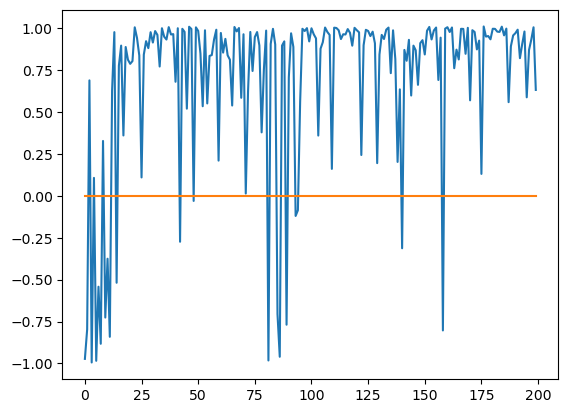

In [27]:
df = pd.DataFrame(results)
df["Y"].plot()
df["trial_id"].plot()

<AxesSubplot:>

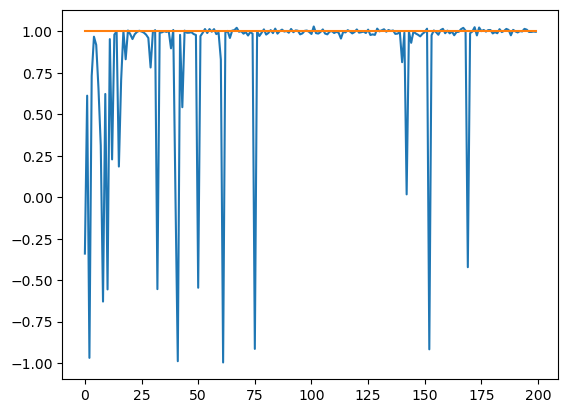

In [25]:
df = pd.DataFrame(results)
df["Y"].plot()
df["trial_id"].plot()

In [16]:
fcm_m.functors['X1'].functional.optimizer.best_x

AttributeError: 'function' object has no attribute 'optimizer'

In [24]:
sum([fcm_m.sample()["Y"] for i in range(1000)])/1000

buffer {}
{'C': tensor(0.3349)} {'U1': tensor(0.3719), 'U2': tensor(0.7512), 'C': tensor(0.3349)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.7771)} {'U1': tensor(0.7568), 'U2': tensor(0.8532), 'C': tensor(0.7771)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.0657)} {'U1': tensor(-0.0564), 'U2': tensor(0.7644), 'C': tensor(-0.0657)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4529)} {'U1': tensor(-0.5128), 'U2': tensor(-0.6284), 'C': tensor(-0.4529)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.5106)} {'U1': tensor(-0.4139), 'U2': tensor(0.7545), 'C': tensor(-0.5106)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.8877)} {'U1': tensor(-0.7459), 'U2': tensor(0.3416), 'C': tensor(-0.8877)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1970)} {'U1': tensor(-0.4769), 'U2': tensor(0.4977), 'C': tensor(-0.1970)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4069)} {'U1': tensor(0.1989), 'U2': tensor(0.1013), 'C': tensor(0.4069)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.8208)} {'U1': tensor(0.8586), 'U2': tensor(0.4828), 'C'

buffer {}
{'C': tensor(-0.0826)} {'U1': tensor(-0.1725), 'U2': tensor(-0.2601), 'C': tensor(-0.0826)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.7305)} {'U1': tensor(-0.7769), 'U2': tensor(0.8565), 'C': tensor(-0.7305)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.2101)} {'U1': tensor(0.1865), 'U2': tensor(0.7967), 'C': tensor(0.2101)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.8682)} {'U1': tensor(-0.8046), 'U2': tensor(0.8763), 'C': tensor(-0.8682)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.8163)} {'U1': tensor(0.7040), 'U2': tensor(0.7685), 'C': tensor(0.8163)} {'C'} {'C'} X1
buffer {}
{'C': tensor(1.1254)} {'U1': tensor(0.9448), 'U2': tensor(-0.6513), 'C': tensor(1.1254)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5405)} {'U1': tensor(0.3392), 'U2': tensor(-0.0293), 'C': tensor(0.5405)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.0810)} {'U1': tensor(0.1673), 'U2': tensor(-0.9943), 'C': tensor(0.0810)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4630)} {'U1': tensor(-0.3076), 'U2': tensor(0.3345), 'C':

buffer {}
{'C': tensor(-0.8831)} {'U1': tensor(-0.9199), 'U2': tensor(0.2879), 'C': tensor(-0.8831)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.8514)} {'U1': tensor(0.9622), 'U2': tensor(-0.9442), 'C': tensor(0.8514)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4965)} {'U1': tensor(0.3669), 'U2': tensor(-0.6430), 'C': tensor(0.4965)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5541)} {'U1': tensor(0.4135), 'U2': tensor(-0.5419), 'C': tensor(0.5541)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.0034)} {'U1': tensor(-0.0057), 'U2': tensor(-0.2678), 'C': tensor(0.0034)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1918)} {'U1': tensor(0.2384), 'U2': tensor(-0.2486), 'C': tensor(0.1918)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.7709)} {'U1': tensor(-0.7085), 'U2': tensor(-0.3898), 'C': tensor(-0.7709)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.9593)} {'U1': tensor(-0.9224), 'U2': tensor(-0.1760), 'C': tensor(-0.9593)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.8826)} {'U1': tensor(-0.7230), 'U2': tensor(0.1477), 

buffer {}
{'C': tensor(0.5760)} {'U1': tensor(0.5169), 'U2': tensor(0.5109), 'C': tensor(0.5760)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.8842)} {'U1': tensor(0.8401), 'U2': tensor(-0.7519), 'C': tensor(0.8842)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.9440)} {'U1': tensor(0.8113), 'U2': tensor(0.2589), 'C': tensor(0.9440)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.6413)} {'U1': tensor(0.4306), 'U2': tensor(-0.7571), 'C': tensor(0.6413)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.3826)} {'U1': tensor(0.4504), 'U2': tensor(0.8981), 'C': tensor(0.3826)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.7998)} {'U1': tensor(-0.8659), 'U2': tensor(-0.1180), 'C': tensor(-0.7998)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5297)} {'U1': tensor(0.5546), 'U2': tensor(0.5995), 'C': tensor(0.5297)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.0143)} {'U1': tensor(-0.0347), 'U2': tensor(0.8202), 'C': tensor(-0.0143)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4345)} {'U1': tensor(0.4569), 'U2': tensor(0.7620), 'C': tenso

buffer {}
{'C': tensor(-0.1189)} {'U1': tensor(-0.0938), 'U2': tensor(0.0194), 'C': tensor(-0.1189)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.6137)} {'U1': tensor(-0.6591), 'U2': tensor(-0.2989), 'C': tensor(-0.6137)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.0524)} {'U1': tensor(-0.0660), 'U2': tensor(-0.5848), 'C': tensor(-0.0524)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.5177)} {'U1': tensor(-0.6928), 'U2': tensor(-0.7024), 'C': tensor(-0.5177)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.5313)} {'U1': tensor(-0.5620), 'U2': tensor(-0.8155), 'C': tensor(-0.5313)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1454)} {'U1': tensor(-0.0175), 'U2': tensor(0.0422), 'C': tensor(0.1454)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.5630)} {'U1': tensor(-0.6514), 'U2': tensor(-0.4816), 'C': tensor(-0.5630)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.3591)} {'U1': tensor(0.3934), 'U2': tensor(-0.8009), 'C': tensor(0.3591)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4661)} {'U1': tensor(-0.5258), 'U2': tensor(-

buffer {}
{'C': tensor(0.9043)} {'U1': tensor(0.8370), 'U2': tensor(0.2800), 'C': tensor(0.9043)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4979)} {'U1': tensor(-0.5933), 'U2': tensor(-0.6975), 'C': tensor(-0.4979)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1955)} {'U1': tensor(0.3159), 'U2': tensor(0.1914), 'C': tensor(0.1955)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.8228)} {'U1': tensor(0.8365), 'U2': tensor(-0.8311), 'C': tensor(0.8228)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1452)} {'U1': tensor(0.0165), 'U2': tensor(0.4228), 'C': tensor(0.1452)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.6527)} {'U1': tensor(0.6728), 'U2': tensor(-0.0269), 'C': tensor(0.6527)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.7418)} {'U1': tensor(0.8572), 'U2': tensor(0.5438), 'C': tensor(0.7418)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-1.1149)} {'U1': tensor(-0.9314), 'U2': tensor(-0.2623), 'C': tensor(-1.1149)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.3576)} {'U1': tensor(-0.4068), 'U2': tensor(0.4516), 'C': te

buffer {}
{'C': tensor(-0.2605)} {'U1': tensor(-0.1974), 'U2': tensor(0.6820), 'C': tensor(-0.2605)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.7080)} {'U1': tensor(-0.6539), 'U2': tensor(-0.5800), 'C': tensor(-0.7080)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1962)} {'U1': tensor(-0.1209), 'U2': tensor(-0.6859), 'C': tensor(-0.1962)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.3317)} {'U1': tensor(-0.3432), 'U2': tensor(0.9108), 'C': tensor(-0.3317)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5358)} {'U1': tensor(0.6242), 'U2': tensor(-0.2945), 'C': tensor(0.5358)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4936)} {'U1': tensor(-0.5909), 'U2': tensor(0.0204), 'C': tensor(-0.4936)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.8006)} {'U1': tensor(-0.7364), 'U2': tensor(0.6268), 'C': tensor(-0.8006)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4201)} {'U1': tensor(0.4380), 'U2': tensor(-0.8074), 'C': tensor(0.4201)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.3488)} {'U1': tensor(-0.4807), 'U2': tensor(0.20

buffer {}
{'C': tensor(0.8632)} {'U1': tensor(0.8400), 'U2': tensor(-0.3019), 'C': tensor(0.8632)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5471)} {'U1': tensor(0.5901), 'U2': tensor(0.4975), 'C': tensor(0.5471)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4346)} {'U1': tensor(-0.3862), 'U2': tensor(-0.3856), 'C': tensor(-0.4346)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1115)} {'U1': tensor(0.0449), 'U2': tensor(-0.0992), 'C': tensor(-0.1115)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.8716)} {'U1': tensor(-0.8064), 'U2': tensor(0.1268), 'C': tensor(-0.8716)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4199)} {'U1': tensor(-0.4835), 'U2': tensor(0.9957), 'C': tensor(-0.4199)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.0742)} {'U1': tensor(-0.0154), 'U2': tensor(-0.1419), 'C': tensor(-0.0742)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.2648)} {'U1': tensor(0.2363), 'U2': tensor(0.5823), 'C': tensor(0.2648)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.2307)} {'U1': tensor(-0.1762), 'U2': tensor(0.2684),

buffer {}
{'C': tensor(-0.7200)} {'U1': tensor(-0.7917), 'U2': tensor(0.8466), 'C': tensor(-0.7200)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4914)} {'U1': tensor(0.5409), 'U2': tensor(-0.5575), 'C': tensor(0.4914)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.3602)} {'U1': tensor(-0.4817), 'U2': tensor(0.1817), 'C': tensor(-0.3602)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.8527)} {'U1': tensor(0.9669), 'U2': tensor(0.8734), 'C': tensor(0.8527)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.2812)} {'U1': tensor(0.2954), 'U2': tensor(-0.5136), 'C': tensor(0.2812)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1320)} {'U1': tensor(-0.1157), 'U2': tensor(0.4703), 'C': tensor(-0.1320)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.8327)} {'U1': tensor(-0.9343), 'U2': tensor(0.7960), 'C': tensor(-0.8327)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4639)} {'U1': tensor(0.4223), 'U2': tensor(0.1996), 'C': tensor(0.4639)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1517)} {'U1': tensor(0.1631), 'U2': tensor(0.7737), 'C': 

buffer {}
{'C': tensor(0.7163)} {'U1': tensor(0.7433), 'U2': tensor(0.1738), 'C': tensor(0.7163)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4338)} {'U1': tensor(0.5537), 'U2': tensor(0.4018), 'C': tensor(0.4338)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1834)} {'U1': tensor(-0.1808), 'U2': tensor(-0.4139), 'C': tensor(-0.1834)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.2210)} {'U1': tensor(0.1760), 'U2': tensor(-0.3728), 'C': tensor(0.2210)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.2724)} {'U1': tensor(0.1958), 'U2': tensor(-0.3086), 'C': tensor(0.2724)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.0632)} {'U1': tensor(-0.0409), 'U2': tensor(-0.3894), 'C': tensor(-0.0632)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5110)} {'U1': tensor(0.6527), 'U2': tensor(-0.9544), 'C': tensor(0.5110)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1151)} {'U1': tensor(-0.0863), 'U2': tensor(0.8031), 'C': tensor(-0.1151)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-1.0386)} {'U1': tensor(-0.9930), 'U2': tensor(-0.3480), 'C

buffer {}
{'C': tensor(-0.6770)} {'U1': tensor(-0.7848), 'U2': tensor(0.7386), 'C': tensor(-0.6770)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.2808)} {'U1': tensor(0.3138), 'U2': tensor(-0.9476), 'C': tensor(0.2808)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.0668)} {'U1': tensor(0.1259), 'U2': tensor(-0.4100), 'C': tensor(0.0668)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.3069)} {'U1': tensor(-0.1921), 'U2': tensor(0.5152), 'C': tensor(-0.3069)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4478)} {'U1': tensor(0.3611), 'U2': tensor(0.3289), 'C': tensor(0.4478)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.6927)} {'U1': tensor(-0.8606), 'U2': tensor(-0.6609), 'C': tensor(-0.6927)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1773)} {'U1': tensor(0.2386), 'U2': tensor(-0.4545), 'C': tensor(0.1773)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1060)} {'U1': tensor(-0.2210), 'U2': tensor(-0.7924), 'C': tensor(-0.1060)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.0553)} {'U1': tensor(-0.1733), 'U2': tensor(0.2183), 

buffer {}
{'C': tensor(-0.3746)} {'U1': tensor(-0.4899), 'U2': tensor(0.5303), 'C': tensor(-0.3746)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1851)} {'U1': tensor(0.1951), 'U2': tensor(0.6746), 'C': tensor(0.1851)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5059)} {'U1': tensor(0.5822), 'U2': tensor(-0.6482), 'C': tensor(0.5059)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.8479)} {'U1': tensor(-0.7988), 'U2': tensor(-0.7120), 'C': tensor(-0.8479)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4502)} {'U1': tensor(0.4586), 'U2': tensor(0.4371), 'C': tensor(0.4502)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.3096)} {'U1': tensor(-0.4339), 'U2': tensor(0.3793), 'C': tensor(-0.3096)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-1.0461)} {'U1': tensor(-0.9740), 'U2': tensor(0.9017), 'C': tensor(-1.0461)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.3604)} {'U1': tensor(0.1088), 'U2': tensor(0.0483), 'C': tensor(0.3604)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4458)} {'U1': tensor(-0.4618), 'U2': tensor(0.5717), 'C'

buffer {}
{'C': tensor(0.9711)} {'U1': tensor(0.9691), 'U2': tensor(-0.2759), 'C': tensor(0.9711)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.3080)} {'U1': tensor(-0.2169), 'U2': tensor(-0.0886), 'C': tensor(-0.3080)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1525)} {'U1': tensor(-0.0877), 'U2': tensor(-0.4516), 'C': tensor(-0.1525)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.5952)} {'U1': tensor(-0.4424), 'U2': tensor(0.3671), 'C': tensor(-0.5952)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.2978)} {'U1': tensor(-0.4826), 'U2': tensor(0.6547), 'C': tensor(-0.2978)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.9360)} {'U1': tensor(-0.9212), 'U2': tensor(-0.2856), 'C': tensor(-0.9360)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.7938)} {'U1': tensor(-0.8422), 'U2': tensor(-0.9802), 'C': tensor(-0.7938)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.7554)} {'U1': tensor(0.7457), 'U2': tensor(-0.3465), 'C': tensor(0.7554)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.2671)} {'U1': tensor(0.3315), 'U2': tensor(-0.6

buffer {}
{'C': tensor(-0.6224)} {'U1': tensor(-0.6409), 'U2': tensor(-0.1234), 'C': tensor(-0.6224)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.5573)} {'U1': tensor(-0.6019), 'U2': tensor(0.5680), 'C': tensor(-0.5573)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.7920)} {'U1': tensor(-0.7927), 'U2': tensor(-0.7087), 'C': tensor(-0.7920)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1150)} {'U1': tensor(0.1502), 'U2': tensor(0.8838), 'C': tensor(0.1150)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1073)} {'U1': tensor(-0.0371), 'U2': tensor(0.3344), 'C': tensor(0.1073)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4883)} {'U1': tensor(0.5051), 'U2': tensor(0.9682), 'C': tensor(0.4883)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.9867)} {'U1': tensor(-0.9137), 'U2': tensor(-0.5154), 'C': tensor(-0.9867)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5191)} {'U1': tensor(0.3431), 'U2': tensor(-0.6637), 'C': tensor(0.5191)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.6618)} {'U1': tensor(0.4974), 'U2': tensor(0.2298), 'C

tensor(0.8081)

In [18]:
g = graph_under_mps[-2]
print(g[1])
MPSReductor.sufficiently_not_pomp(g[1], g[0])

<X2, {'C'}>
{'C'}
call
{'X2', 'C'} {'C'}
{'X2', 'C'} {'X2', 'C'}


False

In [27]:
g[0].uc_variables

{'U1'}

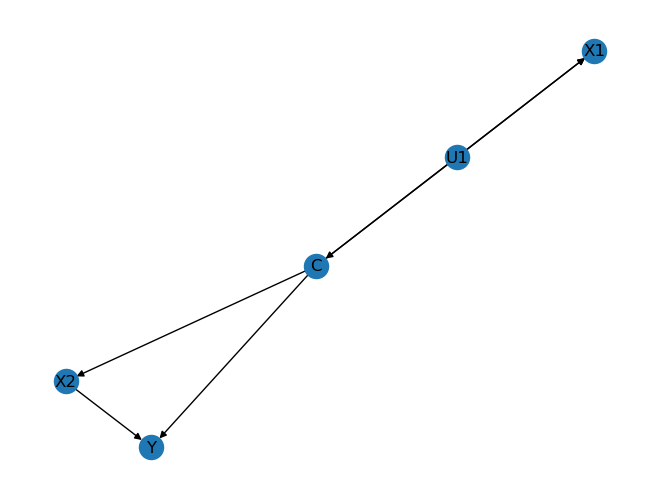

In [28]:
nx.draw(g[0], with_labels=True)

In [15]:
for idx, g in enumerate(graph_under_mps):
    print(idx, g[1])
    MPSReductor.sufficiently_not_pomp(g[1], g[0])

0 
1 <X2, set()>
set()
call
{'X2'} set()
{'X2'} {'X2'}
set()
call
{'X2'} set()
{'X2'} {'X2'}
2 <X2, {'C'}>
{'C'}
call
{'X2', 'C'} {'C'}
{'X2', 'C'} {'X2', 'C'}
3 <X2, {'X1'}>
{'X1'}
call
{'X2', 'X1'} {'X1'}
{'X2', 'X1'} {'X2', 'X1'}
4 <X1, set()>
set()
call
{'X1'} set()
{'X1'} {'X1'}
5 <X1, {'C'}>
6 <X2, {'X1'}>	<X1, {'C'}>
{'X1'}
call
{'X2', 'X1'} {'X1'}
{'X2', 'X1'} {'X2', 'X1'}


In [10]:
mps = MixedPolicyScope(dict())
MPSDAGController.graph_under_mps(mps, ccg), mps

((<pomps.contextual_graphs.ContextualCausalGraph at 0x7f8e610e3130>, True), )

In [8]:
g = graph_under_mps[0]
MPSReductor.sufficiently_not_pomp(g[1], g[0][0])

False

In [9]:
g

((<pomps.contextual_graphs.ContextualCausalGraph at 0x7fed29561520>, True),
 <statin, set()>)

In [16]:
graph_under_mps[1]

((<pomps.contextual_graphs.ContextualCausalGraph at 0x7fcde0cb9580>, True),
 <aspirin, {'age'}>)

In [18]:
MPSReductor.action_relevance_check(graph_under_mps[0][1], graph_under_mps[0][0][0])

True

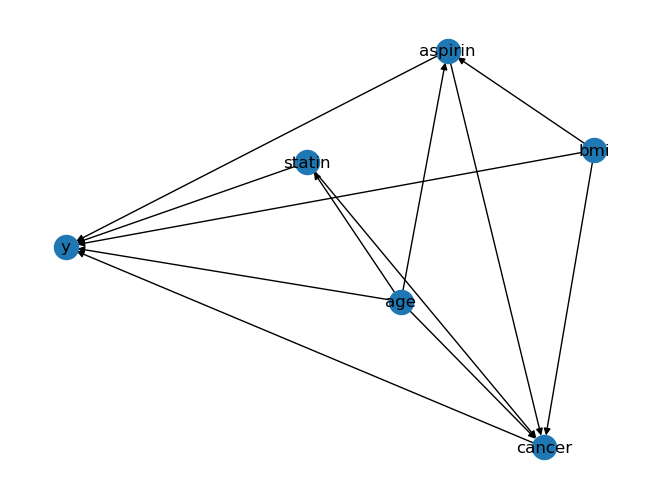

In [36]:
nx.draw(graph_under_mps[i][0], with_labels=True)

In [96]:
inter_segment = []
for inter in interventional_set:
    inter_segment += [[(inter, i) for i in contexts]]

In [104]:
iam = all_combs(inter_segment)
list(itertools.chain(*[(itertools.product(*iam[i])) for i in range(len(iam))], []))

[(),
 (('X1', ()),),
 (('X1', ('C2',)),),
 (('X1', ('C1',)),),
 (('X1', ('C2', 'C1')),),
 (('X2', ()),),
 (('X2', ('C2',)),),
 (('X2', ('C1',)),),
 (('X2', ('C2', 'C1')),),
 (('X1', ()), ('X2', ())),
 (('X1', ()), ('X2', ('C2',))),
 (('X1', ()), ('X2', ('C1',))),
 (('X1', ()), ('X2', ('C2', 'C1'))),
 (('X1', ('C2',)), ('X2', ())),
 (('X1', ('C2',)), ('X2', ('C2',))),
 (('X1', ('C2',)), ('X2', ('C1',))),
 (('X1', ('C2',)), ('X2', ('C2', 'C1'))),
 (('X1', ('C1',)), ('X2', ())),
 (('X1', ('C1',)), ('X2', ('C2',))),
 (('X1', ('C1',)), ('X2', ('C1',))),
 (('X1', ('C1',)), ('X2', ('C2', 'C1'))),
 (('X1', ('C2', 'C1')), ('X2', ())),
 (('X1', ('C2', 'C1')), ('X2', ('C2',))),
 (('X1', ('C2', 'C1')), ('X2', ('C1',))),
 (('X1', ('C2', 'C1')), ('X2', ('C2', 'C1')))]

In [100]:
list(itertools.product(interventional_set, contexts))

[('X1', ()),
 ('X1', ('C2',)),
 ('X1', ('C1',)),
 ('X1', ('C2', 'C1')),
 ('X2', ()),
 ('X2', ('C2',)),
 ('X2', ('C1',)),
 ('X2', ('C2', 'C1'))]